#### Python implementation of frequency domain differentiation.

In [1]:
import mpld3
import numpy as np
from numpy.fft import fft,ifft,fftfreq
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
mpld3.enable_notebook()

In [2]:
def diff_freq_domain(y,dt):
    ''' 
    Calculates the derivative of y in the frequency domain by
    multiplying its spectrum by i*omega
    
    positional arguments--------------------------------------
    y: the signal to be differentiated
    dt: sample spacing
    
    returns---------------------------------------------------
    dy: the differentiated signal
    '''
    z = fft(y)
    
    freqs = np.fft.fftfreq(len(y),dt)
    freqs *= (2.*np.pi)
    
    dy = np.real(np.fft.ifft(1.0j * freqs * np.fft.fft(y)))
    return dy

#### Generate a Gaussian test signal

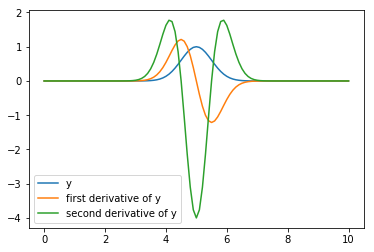

In [3]:
dt = 0.1
T = 10.0
x = np.arange(0,T+dt,dt)
y = signal.gaussian(len(x),5.0)
dy = diff_freq_domain(y,dt=dt)
ddy = diff_freq_domain(dy,dt=dt)

plt.plot(x,y,label='y')
plt.plot(x,dy.real,label='first derivative of y')
plt.plot(x,ddy.real,label='second derivative of y')
plt.legend()

#### Plot power spectrum of signals

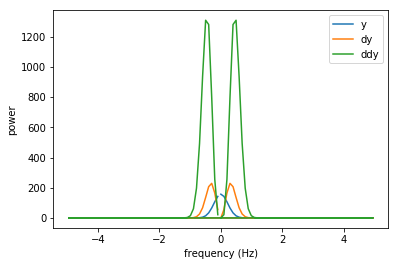

In [4]:
w = fftfreq(len(y),dt)
y_w = fft(y)
dy_w = fft(dy)
ddy_w = fft(ddy)

plt.plot(w,np.abs(y_w)**2,label='y')
plt.plot(w,np.abs(dy_w)**2,label='dy')
plt.plot(w,np.abs(ddy_w)**2,label='ddy')
plt.xlabel('frequency (Hz)')
plt.ylabel('power')
plt.legend()

#### Test with instaseis seismograms

ReciprocalInstaseisDB reciprocal Green's function Database (v10) generated with these parameters:
	components           : vertical and horizontal
	velocity model       : external
	attenuation          : False
	dominant period      : 5.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 1.249 s
	sampling rate        : 0.801 Hz
	number of samples    : 2883
	seismogram length    : 3599.0 s
	source time function : gauss_0
	source shift         : 8.742 s
	spatial order        : 4
	min/max radius       : 3369.5 - 3389.5 km
	Planet radius        : 3389.5 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : symplec4
	compiler/user        : gfortran 6.1.0 by UNKNOWN on UNKNOWN
	directory/url        : axisem_databases/Mars_EH45Tcold_5s_noatten_database
	size of netCDF files : 2.4 GB
	generated by AxiSEM version UNKNOWN at 2018-07-10T23:56:59.000000Z

Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :    

Text(0,0.5,'velocity (m/s)')

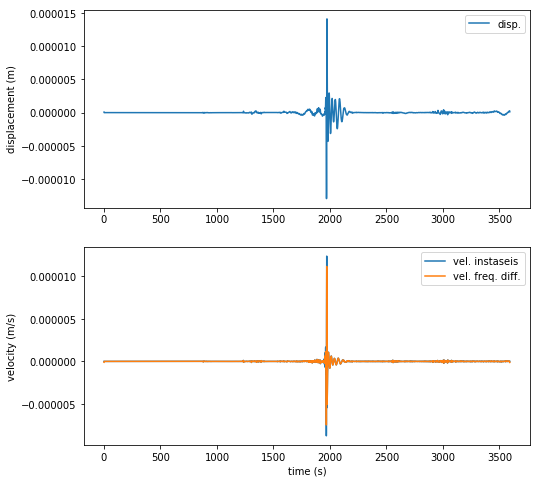

In [13]:
import instaseis

db = instaseis.open_db('/home/romaguir/Documents/axisem_databases/\
Mars_EH45Tcold_5s_noatten_database/')
print db
Mo = 3.98e16#*30.0
source = instaseis.Source(longitude=0.0,latitude=0.0,depth_in_m=1000,
                         m_rr=Mo,m_pp=-Mo)
receiver = instaseis.Receiver(longitude=120.0,latitude=0.0)
st_disp = db.get_seismograms(source,receiver,components='Z',
                             kind='displacement')
st_vel = db.get_seismograms(source,receiver,components='Z',
                             kind='velocity')
st_acc = db.get_seismograms(source,receiver,components='Z',
                             kind='acceleration')
print source

st_disp.resample(2.0)
st_vel.resample(2.0)
st_acc.resample(2.0)

n = st_disp[0].stats.npts
fs = st_disp[0].stats.sampling_rate
dt = 1./fs
L = n*dt
print L
print dt
time = np.linspace(0,L,n)

#frequency domain derivative
vel_fd = diff_freq_domain(st_disp[0].data,dt=dt)

#plot
fig,ax = plt.subplots(nrows=2,figsize=(8,8))
ax[0].plot(time,st_disp[0].data,label='disp.')
ax[0].legend()
ax[0].set_ylabel('displacement (m)')

ax[1].plot(time,st_vel[0].data,label='vel. instaseis')
ax[1].plot(time,vel_fd,label='vel. freq. diff.')
ax[1].legend()
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('velocity (m/s)')

#### Test various ways of computing power spectrum / power spectral density

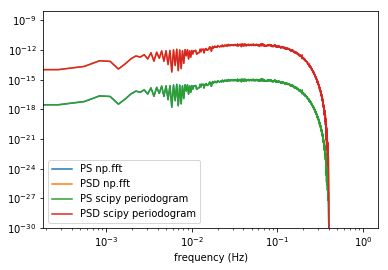

In [6]:
from scipy.signal import get_window
data = st_disp[0].data
window = get_window('boxcar',len(data))

#Method 1---
#calculate the power spectrum of the displacement seismogram using the numpy fft
data_w = fft(data)
freqs = fftfreq(len(data),dt)
scale_ps = 1.0 /window.sum()**2
power_a = (np.abs(data_w)**2)*scale_ps*2. #multiply power spectrum by 2 for 'one sided' spectrum

#Method 2---
#calculate the power spectral density the displacement seismogram using the numpy fft
data_w = fft(data)
freqs = fftfreq(len(data),dt)
scale_psd = 1.0 / (fs * (window*window).sum())
power_b = (np.abs(data_w)**2)*scale_psd*2. #multiply power spectrum by 2 for 'one sided' spectrum

#Method 3---
#calculate power spectrum using scipy.signal.periodogram with 'spectrum' scaling
f,power_c = signal.periodogram(data,fs,scaling='spectrum')

#Method 4---
#calculate power spectral density scipy.signal.periodogram with 'density' scaling
f,power_d = signal.periodogram(data,fs,scaling='density')

#plot
plt.loglog(freqs,power_a,label='PS np.fft')
plt.loglog(freqs,power_b,label='PSD np.fft')
plt.loglog(f,power_c,label='PS scipy periodogram')
plt.loglog(f,power_d,label='PSD scipy periodogram')
plt.xlabel('frequency (Hz)')
plt.ylim([1e-30,1e-8])
plt.legend()

#### Amplitude spectrum of instaseis 'acceleration' time series vs two frequency domain derivatives of instaseis 'displacement' time series

/home/romaguir/anaconda2/lib/python2.7/site-packages/mpld3/mplexporter/exporter.py:179: UserWarning: Legend element <matplotlib.offsetbox.HPacker object at 0x7fcc59404d90> not impemented
  warnings.warn("Legend element %s not impemented" % child)


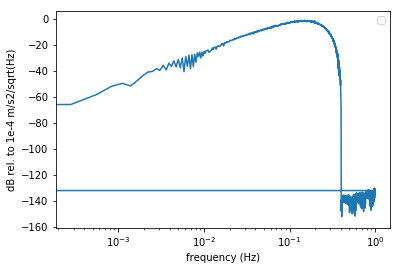

In [7]:
data_vel = diff_freq_domain(st_disp[0].data,st_disp[0].stats.delta)
data_acc = diff_freq_domain(data_vel,st_disp[0].stats.delta)
f,Pxx1 = signal.periodogram(data_acc,st_disp[0].stats.sampling_rate,scaling='spectrum')
f,Pxx2 = signal.periodogram(st_acc[0].data,st_acc[0].stats.sampling_rate,scaling='spectrum')

data_w = fft(data_acc)
f = fftfreq(len(data_acc),dt)
#scale_ps = 1.0 /window.sum()**2
Pxx1 = (np.abs(data_w)**2)#*scale_ps*2.

#Pxx1 *= Mo
#Pxx2 *= Mo
Pxx1 = np.sqrt(Pxx1)
Pxx2 = np.sqrt(Pxx2)

#plt.loglog(f,10.0*np.log10(Pxx1),label='2 freq. domain derivatives of disp.')
#plt.loglog(f,10.0*np.log10(Pxx2),label='instaseis accel. spectrum')
plt.semilogx(f,10*np.log10(Pxx1/1e-4))
#plt.semilogy(f,10.0*np.log10(Pxx2))
plt.xlabel('frequency (Hz)')
plt.ylabel('dB rel. to 1e-4 m/s2/sqrt(Hz)')
plt.legend()
#plt.ylim([1e-15,1e-4])

In [8]:
print np.max(10*np.log10(Pxx1/1e-4))

-1.2184363011323094


0.0
0.20408163265306123
0.40816326530612246
0.6122448979591837
0.8163265306122449
1.0204081632653061
1.2244897959183674
1.4285714285714286
1.6326530612244898
1.836734693877551
2.0408163265306123
2.2448979591836737
2.4489795918367347
2.6530612244897958
2.857142857142857
3.0612244897959187
3.2653061224489797
3.4693877551020407
3.673469387755102
3.8775510204081636
4.081632653061225
4.285714285714286
4.4897959183673475
4.6938775510204085
4.8979591836734695
5.1020408163265305
5.3061224489795915
5.510204081632653
5.714285714285714
5.918367346938775
6.122448979591837
6.326530612244898
6.530612244897959
6.73469387755102
6.938775510204081
7.142857142857143
7.346938775510204
7.551020408163265
7.755102040816327
7.959183673469388
8.16326530612245
8.36734693877551
8.571428571428571
8.775510204081632
8.979591836734695
9.183673469387756
9.387755102040817
9.591836734693878
9.795918367346939
10.0


/home/romaguir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10


TypeError: array([1.]) is not JSON serializable

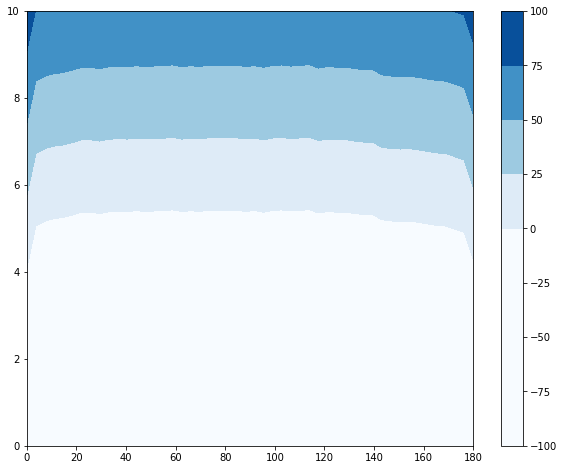

In [14]:
Mws = np.linspace(0,10,50)
gcarcs = np.linspace(0,180,50)

mags = []
dists = []
acc = []

def Mw_to_Mo(Mw):

    Mo = 10.0**(1.5*Mw + 9.1)
    return Mo

def get_max_accel(Mw,gcarc):
    
    Mo = Mw_to_Mo(Mw)
    source = instaseis.Source(longitude=0.0,latitude=0.0,depth_in_m=20000,m_rr=Mo,m_pp=-Mo)
    receiver = instaseis.Receiver(longitude=gcarc,latitude=0.0)
    st_disp = db.get_seismograms(source,receiver,components='Z',kind='displacement')
    data_vel = diff_freq_domain(st_disp[0].data,st_disp[0].stats.delta)
    data_acc = diff_freq_domain(data_vel,st_disp[0].stats.delta)
    data_w = fft(data_acc)
    f = fftfreq(len(data_acc),dt)
    Pxx = (np.abs(data_w)**2)
    Pxx = np.sqrt(Pxx)
    Pxx_db = 10*np.log10(Pxx/1e-4)
    
    return np.max(Pxx_db)

for Mw in Mws:
    
    print Mw
    for gcarc in gcarcs:
        acc_dB = get_max_accel(Mw,gcarc)
        mags.append(Mw)
        dists.append(gcarc)
        acc.append(acc_dB)

image = np.reshape(acc,(len(Mws),len(gcarcs)))
fig,ax = plt.subplots(1,figsize=(10,8))
plt.contourf(gcarcs,Mws,image,vmin=0.0,cmap='Blues')
plt.colorbar()
#plt.contourf(dists,mags,c=acc,edgecolor=None)

TypeError: array([1.]) is not JSON serializable

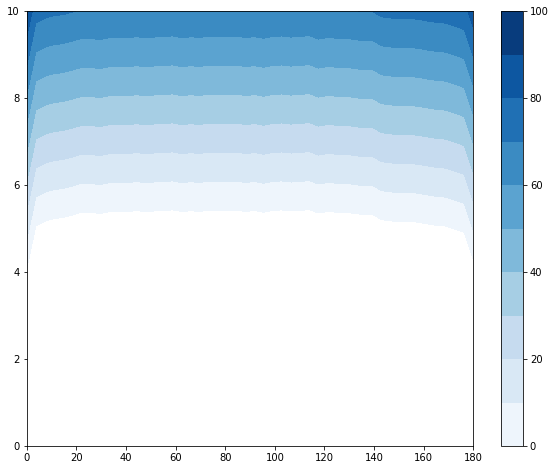

In [15]:
fig,ax = plt.subplots(1,figsize=(10,8))
plt.contourf(gcarcs,Mws,image,levels=[0,10,20,30,40,50,60,70,80,90,100],cmap='Blues')
plt.colorbar()